<a href="https://colab.research.google.com/github/bobby-he/Neural_Tangent_Kernel/blob/master/GANimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!git clone https://github.com/bobby-he/Neural_Tangent_Kernel.git

Cloning into 'Neural_Tangent_Kernel'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 238 (delta 24), reused 10 (delta 4), pack-reused 191
Receiving objects: 100% (238/238), 21.88 MiB | 32.24 MiB/s, done.
Resolving deltas: 100% (107/107), done.


In [0]:
from Neural_Tangent_Kernel.src.NTK_net import LinearNeuralTangentKernel, FourLayersNet, train_net, circle_transform, variance_est, cpu_tuple,\
                                              AnimationPlot_lsq, kernel_leastsq_update, kernel_mats

In [0]:
import time

In [0]:

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [0]:
from matplotlib import animation, rc
from IPython.display import HTML
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set2.colors)

In [0]:
def get_distribution_sampler(mu, sigma):
    return lambda n: torch.Tensor(np.random.normal(mu, sigma, (n, 1)))  # Gaussian

def get_generator_input_sampler():
    return lambda n: circle_transform(2*np.pi * torch.rand(n, 1)- np.pi).reshape((n,2))  # Uniform-dist data into generator, _NOT_ Gaussian


In [0]:
# ##### MODELS: Generator model and discriminator model

class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, f):
        super(Generator, self).__init__()
        self.map1 = LinearNeuralTangentKernel(input_size, hidden_size, w_sig = 1, beta = 0.01)
        self.map2 = LinearNeuralTangentKernel(hidden_size, hidden_size, w_sig = np.sqrt(5), beta = 0.01)
        self.map3 = LinearNeuralTangentKernel(hidden_size, output_size, w_sig = np.sqrt(5), beta = 0.01)
        self.f = f

    def forward(self, x):
        x = self.map1(x)
        x = self.f(x)
        x = self.map2(x)
        x = self.f(x)
        x = self.map3(x)
        return x

class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, f):
        super(Discriminator, self).__init__()
        self.map1 = LinearNeuralTangentKernel(input_size, hidden_size, w_sig = 1)
        self.map2 = LinearNeuralTangentKernel(hidden_size, hidden_size, w_sig = np.sqrt(10))
        self.map3 = LinearNeuralTangentKernel(hidden_size, output_size, w_sig = np.sqrt(10))
        self.f = f

    def forward(self, x):
        x = self.f(self.map1(x))
        x = self.f(self.map2(x))
        x = self.f(self.map3(x))
        return x


In [0]:
def extract(v):
    return v.data.storage().tolist()

In [0]:

class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, f):
        super(Generator, self).__init__()
        self.map1 = LinearNeuralTangentKernel(input_size, hidden_size, w_sig = 1, beta = 0.1)
        self.map2 = LinearNeuralTangentKernel(hidden_size, hidden_size, w_sig = np.sqrt(5), beta = 0.1)
        self.map3 = LinearNeuralTangentKernel(hidden_size, output_size, w_sig = np.sqrt(5), beta = 0.1)
        #self.map4 = LinearNeuralTangentKernel(hidden_size, output_size, w_sig = np.sqrt(5), beta = 0.1)
        self.f = f

    def forward(self, x):
        x = self.map1(x)
        x = self.f(x)
        x = self.map2(x)
        x = self.f(x)
        x = self.map3(x)
        #x = self.f(x)
        #x = self.map4(x)
        return x
g_hidden_size = 500
d_hidden_size = 500      
generator_activation_function = torch.tanh
discriminator_activation_function = torch.sigmoid
G = Generator(input_size = 2,
                  hidden_size=g_hidden_size,
                  output_size = 1,
                  f=generator_activation_function).cuda()   

D = Discriminator(input_size = 1,
                  hidden_size=d_hidden_size,
                  output_size = 1,
                  f=discriminator_activation_function).cuda()

In [0]:
class GANimation(object):
  def __init__(self, generator, discriminator, line_tuple, fig, ax, g_learning_rate = 0.0001, d_learning_rate = 0.0001,
               momentum = 0.9, minibatch_size = 10, dis_iterations = 3, g_iterations = 3, n_pts = 100,
               print_every = 50, epochs_per_frame = 100, data_mean = 2, data_stddev = 1.25,
               use_cuda = True):
    self.G = generator
    self.G_opt = optim.SGD(self.G.parameters(), lr=d_learning_rate, momentum=momentum)
    self.D = discriminator
    self.D_opt = optim.SGD(self.D.parameters(), lr=d_learning_rate, momentum=momentum)
    self.dis_iterations = dis_iterations
    self.g_iterations = g_iterations
    self.minibatch_size = minibatch_size
    self.data_mean = data_mean
    self.data_stddev = data_stddev
    self.g_backprop_line, self.d_backprop_line = line_tuple
    self.ax = ax
    self.fig = fig
    self.n_pts = n_pts
    self.g_test_data = torch.tensor(np.linspace(-np.pi, np.pi, n_pts)).float()
    self.d_test_data = torch.tensor(np.linspace(data_mean - 4*data_stddev, 
                                                data_mean + 4 *data_stddev, n_pts)).float()
    self.print_every = print_every
    self.epochs_per_frame = epochs_per_frame
    self.use_cuda = use_cuda
    self.criterion = nn.BCELoss() 
    self.valid = Variable(torch.ones([minibatch_size,1])).cuda()
    self.fake = Variable(torch.zeros([minibatch_size,1])).cuda()

    self.g_lr = g_learning_rate
    self.d_lr = d_learning_rate
    self.momentum = momentum
    
    if self.use_cuda:
      self.G.cuda()
      self.D.cuda()
    
    self.d_sampler = get_distribution_sampler(self.data_mean, self.data_stddev)
    self.g_sampler = get_generator_input_sampler()
    
    # and finally, the kernel approximation
    self.g_test_input = circle_transform(self.g_test_data).cuda()
    self.kernel_output = self.G(self.g_test_input)
    self.prev_kernel_output = self.G(self.g_test_input)
    
  def _generator_train_step(self, fake_data):
    self.G_opt.zero_grad()
    d_fake = self.D(fake_data)

    # calculate loss and optimise
    g_loss = self.criterion(d_fake, self.valid)
    g_loss.backward()
    self.G_opt.step()

  def _discriminator_train_step(self, real_data, fake_data):
    # save factors used in label smoothing
    self.D_opt.zero_grad()
    d_fake = self.D(fake_data)
    d_real = self.D(real_data)

    # calculate loss and optimise
    real_loss = self.criterion(d_real, 0.9*self.valid)
    fake_loss = self.criterion(d_fake, self.fake)
    d_loss = real_loss + fake_loss

    d_loss.backward()
    self.D_opt.step()

  def epoch_step(self, i):
    j = 0
    if i%10==0 and i!=0:
      print('{} steps gone'.format(i) )
    if i>2:
      for epoch in range(self.epochs_per_frame):
        for dis_update in range(self.dis_iterations):
          real_data = self.d_sampler(self.minibatch_size).cuda()
          gen_samples = self.g_sampler(self.minibatch_size)
          fake_data = self.G(gen_samples.cuda())
          self._discriminator_train_step(real_data, fake_data)
          
          # now apply kernel update
          
        for g_update in range(self.g_iterations):
          gen_samples = self.g_sampler(self.minibatch_size)
          fake_data = self.G(gen_samples.cuda())
          self._generator_train_step(fake_data)
      j = i-2

    self.fig.suptitle('Epoch {}'.format(self.epochs_per_frame *j))
    g_current = self.G(circle_transform(self.g_test_data).cuda()).cpu().detach().numpy() 
    self.g_backprop_line.set_data(self.g_test_data.numpy(), g_current)

    self.d_backprop_line.set_data(self.d_test_data.numpy(), self.D(self.d_test_data.cuda().reshape((self.n_pts,1))).cpu().detach().numpy())
    
    self.ax[1,0].clear()
    self.ax[1,0].set_title('Approx Backprop Histogram')
    self.ax[1,0].set_ylim((0,2))
    self.ax[1,0].set_xlim((self.data_mean - 4 * self.data_stddev,self.data_mean + 4 * self.data_stddev))
    self.ax[1,0].hist(g_current, bins = np.linspace(data_mean - 3 * data_stddev, data_mean + 3 * data_stddev, 20), density = True)
    return(self.g_backprop_line, self.d_backprop_line,)

In [29]:
data_mean = 4
data_stddev = 1.5
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (15,15))
plt.subplots_adjust(wspace=0.25,hspace=0.35)
plt.close()

ax[0,0].set_xlim((-np.pi, np.pi))
ax[0,0].set_ylim((data_mean - 4 * data_stddev, data_mean + 4 * data_stddev))
ax[0,1].set_xlim((data_mean - 4 * data_stddev, data_mean + 4 * data_stddev))
ax[0,1].set_ylim((0,1))
ax[0,0].set_xlabel('$z$')
ax[0,0].set_ylabel('$G_{ \\theta}(z)$')
ax[0,1].set_xlabel('$x$')
ax[0,1].set_ylabel('$D_{ \phi}(x)$')
ax[1,0].set_xlim((data_mean - 2 * data_stddev,data_mean + 2 * data_stddev))
ax[1,1].set_xlim((data_mean - 2 * data_stddev,data_mean + 2 * data_stddev))
ax[1,0].set_ylim((0,1))
ax[1,1].set_ylim((0,1.5))
ax[0,0].set_title('Generator')
ax[0,1].set_title('Discriminator')
ax[1,1].set_title('Approx Kernel Histogram')
ax[1,0].set_title('Approx Backprop Histogram')
line0, = ax[0,0].plot([], [], lw=2, color = 'darkmagenta', label = 'Mean')
line1, = ax[0,1].plot([], [], lw=2, color = 'red')
#hist0 = ax[1,0].hist([], bins = np.linspace(data_mean - 2 * data_stddev, data_mean + 2 * data_stddev, 20), density = True)
#hist1 = ax[1,0].hist([], bins = np.linspace(data_mean - 2 * data_stddev, data_mean + 2 * data_stddev, 20), density = True)
line_tuple = (line0, line1)#, hist0, hist1)


g_hidden_size = 500
d_hidden_size = 500      
generator_activation_function = torch.tanh
discriminator_activation_function = torch.sigmoid
G = Generator(input_size = 2,
                  hidden_size=g_hidden_size,
                  output_size = 1,
                  f=generator_activation_function).cuda()   

D = Discriminator(input_size = 1,
                  hidden_size=d_hidden_size,
                  output_size = 1,
                  f=discriminator_activation_function).cuda()
GAN = GANimation(G,D, data_mean = data_mean, data_stddev = data_stddev, line_tuple = line_tuple, ax = ax, fig = fig, epochs_per_frame=50)


start=time.time()
anim = animation.FuncAnimation(fig, GAN.epoch_step, frames = 100, interval = 150, blit = True)
rc('animation', html='jshtml')
anim

10 steps gone
20 steps gone
30 steps gone
40 steps gone
50 steps gone
60 steps gone
70 steps gone
80 steps gone
90 steps gone


In [0]:
end = time.time()-start

In [387]:
end

123.52674269676208

In [0]:
end = time.time()-start

In [288]:
line0.

11.985645532608032

Plotting the generated distribution...


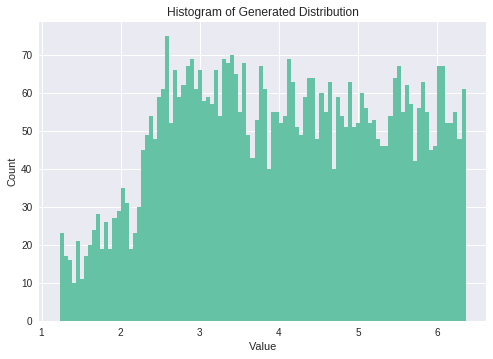

In [123]:
gi_sampler = get_generator_input_sampler()
gen_input = Variable(gi_sampler(5000)).cuda()
g_fake_data = GAN.G(gen_input)

print("Plotting the generated distribution...")
values = extract(g_fake_data)
#print(" Values: %s" % (str(values)))
plt.clf()
plt.hist(values, bins=100)
plt.xlabel('Value')
plt.ylabel('Count')
plt.title('Histogram of Generated Distribution')
plt.grid(True)
plt.show()

Investigating peculiarities of the nonlinearity

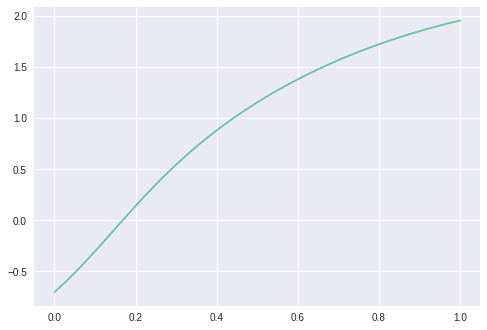

In [284]:
g_hidden_size = 1000
d_hidden_size = 1000
class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, f):
        super(Generator, self).__init__()
        self.map1 = LinearNeuralTangentKernel(input_size, hidden_size, w_sig = 1, beta = 0.1)
        self.map2 = LinearNeuralTangentKernel(hidden_size, hidden_size, w_sig = np.sqrt(5), beta = 0.1)
        self.map3 = LinearNeuralTangentKernel(hidden_size, output_size, w_sig = np.sqrt(5), beta = 0.1)
        #self.map4 = LinearNeuralTangentKernel(hidden_size, output_size, w_sig = np.sqrt(5), beta = 0.1)
        self.f = f

    def forward(self, x):
        x = self.map1(x)
        x = self.f(x)
        x = self.map2(x)
        x = self.f(x)
        x = self.map3(x)
        #x = self.f(x)
        #x = self.map4(x)
        return x
      
generator_activation_function = torch.tanh
G = Generator(input_size = 1,
                  hidden_size=g_hidden_size,
                  output_size = 1,
                  f=generator_activation_function).cuda()      

n_pts = 100
g_test_data = torch.tensor(np.linspace(0, 1, n_pts)).float()


plt.plot(g_test_data.numpy(), G(g_test_data.cuda().reshape((n_pts,1))).cpu().detach().numpy())

In [0]:
data_mean = 4
data_stddev = 1.25
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (10,10))
plt.subplots_adjust(wspace=0.25,hspace=0.35)
plt.close()

ax[0,0].set_xlim((0, 1))
ax[0,0].set_ylim((0, 8))
ax[0,1].set_xlim((0,8))
ax[0,1].set_ylim((0,1))
ax[0,0].set_xlabel('$z$')
ax[0,0].set_ylabel('$G_{ \\theta}(z)$')
ax[0,1].set_xlabel('$x$')
ax[0,1].set_ylabel('$D_{ \phi}(x)$')
ax[1,0].set_xlim((data_mean - 2 * data_stddev,data_mean + 2 * data_stddev))
ax[1,1].set_xlim((data_mean - 2 * data_stddev,data_mean + 2 * data_stddev))
ax[1,0].set_ylim((0,1))
ax[1,1].set_ylim((0,1))
ax[0,0].set_title('Generator')
ax[0,1].set_title('Discriminator')
ax[1,1].set_title('Approx Kernel Histogram')
ax[1,0].set_title('Approx Backprop Histogram')
line0, = ax[0,0].plot([], [], lw=2, color = 'darkmagenta', label = 'Mean')
line1, = ax[0,1].plot([], [], lw=2, color = 'red')
hist0 = ax[1,0].hist([], bins = np.linspace(data_mean - 2 * data_stddev, data_mean + 2 * data_stddev, 20), density = True)
hist1 = ax[1,0].hist([], bins = np.linspace(data_mean - 2 * data_stddev, data_mean + 2 * data_stddev, 20), density = True)
hist0 = ax[1,0].plot()

AttributeError: ignored